In [1]:
import pandas as pd
import numpy as np
import ssl
from pandas_datareader import data, wb
import matplotlib.pyplot as plt
from pandas.util.testing import assert_frame_equal
import datetime as dt
import pandas_datareader.data as web
ssl._create_default_https_context = ssl._create_unverified_context

pd.set_option('display.max_columns', None)

pd.set_option('display.max_rows',30)

pd.set_option('max_colwidth',100)

ssl._create_default_https_context = ssl._create_unverified_context

pd.set_option('display.max_columns', None)

pd.set_option('display.max_rows', None)

pd.set_option('max_colwidth',100)

In [8]:
url=r'https://assets.datacamp.com/production/repositories/1546/datasets/3d9b734fea954b629d2477ef48c36525dfecf6e0/FamaFrenchFactors.csv'
df=pd.read_csv(url)
df['Date']=pd.to_datetime(df['Date'])
df=df.set_index('Date')
df.head()

,Portfolio,Market_Excess,SMB,HML,RMW,CMA,RF
Date,,,,,,,
2013-01-03,-0.005066,-0.0014,0.0014,0.0004,0.0020,0.0023,0.0
2013-01-04,0.004024,0.0055,0.0019,0.0043,-0.0037,0.0027,0.0
2013-01-07,0.004421,-0.0031,-0.0009,-0.0037,-0.0013,-0.0012,0.0
2013-01-08,-0.004659,-0.0027,0.0004,-0.0007,-0.0012,0.0009,0.0
2013-01-09,0.004636,0.0034,0.0024,-0.0041,-0.0007,-0.0015,0.0


## Fama French 3 factor model

In [17]:
# take size factor and value factor into consideration
# Import statsmodels.formula.api
import statsmodels.api as sm

# Define the regression formula
X=df[['Market_Excess',"SMB","HML"]]
y=df["Portfolio"]

Fama=sm.OLS(y,sm.add_constant(X)).fit()


# Extract the adjusted r-squared
regression_adj_rsq = Fama.rsquared_adj
print(regression_adj_rsq)

# Extract the p-value of the SMB factor
smb_pval = Fama.pvalues['SMB']

# If the p-value is significant, print significant
if smb_pval < 0.05:
    significant_msg = 'significant'
else:
    significant_msg = 'not significant'

# Print the SMB coefficient
smb_coeff = Fama.params['SMB']
print("The SMB coefficient is ", smb_coeff, " and is ", significant_msg)

0.8194687130934963
The SMB coefficient is  -0.26215115912476294  and is  significant


## Alpha --intercept--the unexplain performance due to unknowm factors

In [23]:
alpha=Fama.params['const']
alpha

0.00019140256747527117

In [25]:
# Annualize the alpha
alpha_annualized=((1+alpha)**252)-1
alpha_annualized

0.049410766185005395

## 5-factor model

In [26]:
# take size factor and value factor into consideration
# Import statsmodels.formula.api
import statsmodels.api as sm

# Define the regression formula
X=df[['Market_Excess',"SMB","HML","RMW",'CMA']]
y=df["Portfolio"]

Fama5=sm.OLS(y,sm.add_constant(X)).fit()

In [28]:
# Extract the adjusted r-squared
regression_adj_rsq = Fama5.rsquared_adj
print(regression_adj_rsq)

0.8368098114264946


## Tail risk

### Historical Drawdown

In [64]:
# Drawdown can be measured as the percentage loss from the highest cumulative historical point.
url=r"https://assets.datacamp.com/production/repositories/1546/datasets/dfe9da08c986709d59943d1d5c0106537a8c608a/USO.csv"
uso=pd.read_csv(url)
uso['Date']=pd.to_datetime(uso['Date'])
uso=uso.set_index('Date')
uso.head()

,USO
Date,
2007-01-03,-0.042636
2007-01-04,-0.040688
2007-01-05,0.009285
2007-01-08,-0.007109
2007-01-09,-0.004001


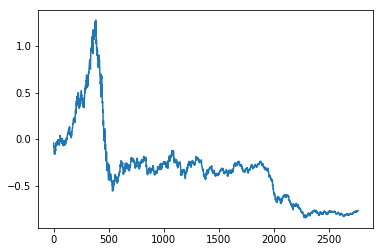

In [30]:
CumulativeReturns = ((1+uso["USO"]).cumprod()-1)
CumulativeReturns.plot()
plt.show()

In [91]:
running=np.maximum.accumulate(uso)
 # find the previous highest point
running.head()

,USO
Date,
2007-01-03,-0.042636
2007-01-04,-0.040688
2007-01-05,0.009285
2007-01-08,0.009285
2007-01-09,0.009285


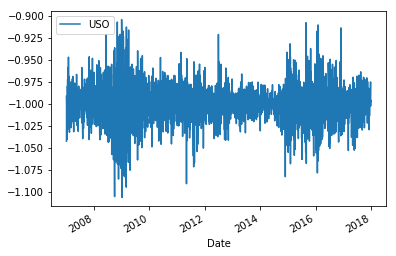

In [96]:
# Ensure the value never drops below 1
running[running<1] = 1
# Calculate the percentage drawdown
drawdown = (uso)/ running-1
drawdown.head()
# Plot the results
drawdown.plot()
plt.show()

## VAR_Value at risk

-0.03608233764037496


/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


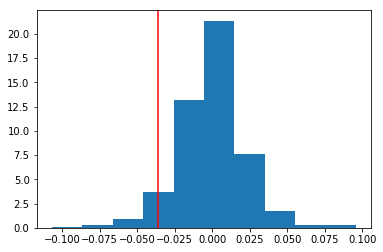

In [72]:
#amount&&&probability

#var(95)=-2.3%
#95%certain that losses will not
#exceed -2.3% in a given day based on historical values


var_95=np.percentile(uso['USO'],100-95)
print(var_95)
sorted_rets = sorted(uso['USO'])

# Plot the probability of each sorted return quantile
plt.hist(sorted_rets, normed=True)

# Denote the VaR 95 quantile
plt.axvline(x=var_95, color='r', linestyle='-', label="VaR 95: {0:.2f}%".format(var_95))
plt.show()



## CVAR-Conditional value at risk

In [70]:
#cvar(95)=-2.5%
# in the worst 5% of cases,losses were on average exceed -2.5% historically

cvar_95 = uso[uso['USO'] <= var_95].mean()
print(cvar_95)


USO   -0.050541
dtype: float64


/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


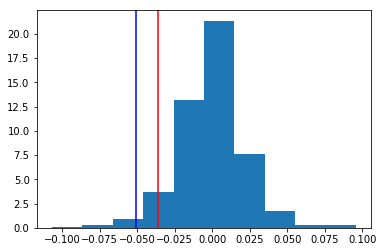

-0.025585126469651758
USO   -0.040432
dtype: float64


In [78]:
# Sort the returns for plotting
sorted_rets = sorted(uso['USO'])

# Plot the probability of each return quantile
plt.hist(sorted_rets, normed=True)

# Denote the VaR 95 and CVaR 95 quantiles
plt.axvline(x=var_95, color="r", linestyle="-", label='VaR 95: {0:.2f}%'.format(var_95))
plt.axvline(x=-0.050541, color='b', linestyle='-', label='CVaR 95: {0:.2f}%'.format(-0.050541))
plt.show()

# Historical VaR quantiles
var_90 = np.percentile(uso['USO'], 10)
print(var_90)

# Historical CVaR quantiles
cvar_90 = uso[uso['USO'] <= var_90].mean()
print(cvar_90)




## Random Walk

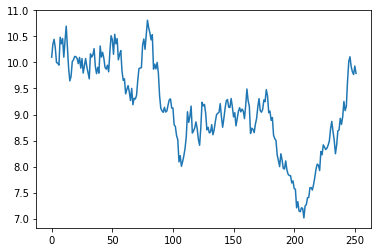

In [88]:
# Set the simulation parameters
mu = np.mean(uso)
vol = np.std(uso)
T = 252
S0 = 10

# Add one to the random returns
rand_rets = np.random.normal(mu,vol,T)+ 1

# Forecasted random walk
forecasted_values = S0*(rand_rets.cumprod())

# Plot the random walk
plt.plot(range(0, T), forecasted_values)
plt.show()

## Monte Carlo Simulations

In [89]:
sim_return=[]
for i in range(100):
    rand_rets=np.random.normal(mu,vol,T)
    sim_return.append(rand_rets)

var_95=np.percentile(sim_return,5)
var_95

-0.03581845972425982

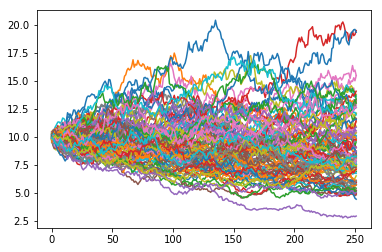

In [90]:
# Loop through 100 simulations
for i in range(100):

    # Generate the random returns
    rand_rets = np.random.normal(mu, vol, T) + 1
    
    # Create the Monte carlo path
    forecasted_values = S0*(rand_rets).cumprod()
    
    # Plot the Monte Carlo path
    plt.plot(range(T), forecasted_values)

# Show the simulations
plt.show()